<a href="https://colab.research.google.com/github/silverstar0727/pragmatism-AI/blob/main/train_ultralytics_yolo(oxpet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/ultralytics/yolov3
!cd yolov3;pip install -qr requirements.txt

Cloning into 'yolov3'...
remote: Enumerating objects: 9862, done.
remote: Total 9862 (delta 0), reused 0 (delta 0), pack-reused 9862
Receiving objects: 100% (9862/9862), 9.19 MiB | 20.37 MiB/s, done.
Resolving deltas: 100% (6667/6667), done.
     |████████████████████████████████| 636 kB 24.9 MB/s 


In [ ]:
import torch
from IPython.display import Image, clear_output  # to display images

clear_output()
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.9.0+cu102 (CPU)


In [ ]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz -q
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz -q

# /content/data 디렉토리를 만들고 해당 디렉토리에 다운로드 받은 압축 파일 풀기.
!mkdir /content/data
!tar -xf images.tar.gz -C /content/data
!tar -xf annotations.tar.gz -C /content/data

mkdir: cannot create directory ‘/content/data’: File exists


아래 코드로 완성된 디렉토리 구조

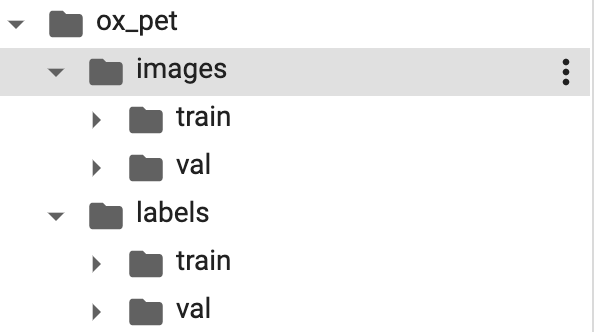

In [ ]:
# Ultralytics Yolo images와 labels 디렉토리를 train, val 용으로 생성
!mkdir /content/ox_pet;
!cd /content/ox_pet; mkdir images; mkdir labels;
!cd /content/ox_pet/images; mkdir train; mkdir val
!cd /content/ox_pet/labels; mkdir train; mkdir val

In [ ]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split

def make_dataframe(txtfile, img_dir, anno_dir, test_size):
    # /content/data/annotations/trainval.txt로부터 dataframe을 만듦
    df = pd.read_csv(txtfile, 
                     sep=' ',
                     header=None,
                     names=['img_name', 'class_id', 'etc1', 'etc2'])
    
    # df에 class_name, img_filepath, anno_filepath를 추가
    ## 클래스(class_name) = 파일이름(img_name)의 "_"문자 이전까지의 이름
    df['class_name'] = df['img_name'].apply(lambda x: x[:x.rfind('_')])
    df['img_filepath'] = img_dir + "/" + df['img_name'] + ".jpg"
    df['anno_filepath'] = anno_dir + "/" + df['img_name'] + ".xml"

    # annotation은 없고 trainval에는 존재하는 파일을 df에서 삭제
    df = remove_no_annos(df) # 아래 별도 함수 지정

    # 데이터 분할
    train_df, val_df = train_test_split(df, test_size=test_size, stratify=df['class_id'], random_state=2021)
    
    return df, train_df, val_df

In [ ]:
# annotation은 없고 trainval에는 존재하는 파일을 df에서 삭제
def remove_no_annos(df):
    remove_rows = []
    for index, row in df.iterrows():
        anno_filepath = row['anno_filepath']

        if not os.path.exists(anno_filepath):
            print(f"존재하지 않는 파일이므로 {anno_filepath}를 삭제")
            remove_rows.append(index)

    df = df.drop(remove_rows, axis=0, inplace=False)

    return df

In [ ]:
df, train_df, val_df = make_dataframe("/content/data/annotations/trainval.txt", 
                                      "/content/data/images", 
                                      "/content/data/annotations/xmls",
                                      0.2)

존재하지 않는 파일이므로 /content/data/annotations/xmls/Abyssinian_104.xml를 삭제
존재하지 않는 파일이므로 /content/data/annotations/xmls/Bengal_111.xml를 삭제
존재하지 않는 파일이므로 /content/data/annotations/xmls/samoyed_10.xml를 삭제
존재하지 않는 파일이므로 /content/data/annotations/xmls/Bengal_175.xml를 삭제
존재하지 않는 파일이므로 /content/data/annotations/xmls/Egyptian_Mau_14.xml를 삭제
존재하지 않는 파일이므로 /content/data/annotations/xmls/Egyptian_Mau_156.xml를 삭제
존재하지 않는 파일이므로 /content/data/annotations/xmls/Egyptian_Mau_186.xml를 삭제
존재하지 않는 파일이므로 /content/data/annotations/xmls/Ragdoll_199.xml를 삭제
존재하지 않는 파일이므로 /content/data/annotations/xmls/saint_bernard_15.xml를 삭제


In [ ]:
import glob
import xml.etree.ElementTree as ET

# 유니크한 클래스 리스트
CLASS_NAMES = df['class_name'].unique().tolist()

# 1개의 voc xml 파일을 Yolo 포맷용 txt 파일로 변경하는 함수 
def xml_to_txt(input_xml_file, output_txt_file, object_name):
  # ElementTree로 입력 XML파일 파싱. 
  tree = ET.parse(input_xml_file)
  root = tree.getroot()
  img_node = root.find('size')
  
  # img_node를 찾지 못하면 종료
  if img_node is None:
    return None

  # 원본 이미지의 너비와 높이 추출. 
  img_width = int(img_node.find('width').text)
  img_height = int(img_node.find('height').text)

  # xml 파일내에 있는 모든 object Element를 찾음. 
  value_str = None
  with open(output_txt_file, 'w') as output_fpointer:
    for obj in root.findall('object'):
        # bndbox를 찾아서 좌상단(xmin, ymin), 우하단(xmax, ymax) 좌표 추출. 
        xmlbox = obj.find('bndbox')
        x1 = int(xmlbox.find('xmin').text)
        y1 = int(xmlbox.find('ymin').text)
        x2 = int(xmlbox.find('xmax').text)
        y2 = int(xmlbox.find('ymax').text)

        # 만약 좌표중에 하나라도 0보다 작은 값이 있으면 종료. 
        if (x1 < 0) or (x2 < 0) or (y1 < 0) or (y2 < 0):
          break

        # object_name과 원본 좌표를 입력하여 Yolo 포맷으로 변환하는 convert_yolo_coord()함수 호출. 
        class_id, cx_norm, cy_norm, w_norm, h_norm = convert_yolo_coord(object_name, 
                                                                        img_width, 
                                                                        img_height, 
                                                                        x1, y1, x2, y2)
        # 변환된 yolo 좌표를 object 별로 출력 text 파일에 write
        value_str = (f'{class_id} {cx_norm} {cy_norm} {w_norm} {h_norm}')
        output_fpointer.write(value_str+'\n')

In [ ]:
# object_name과 원본 좌표를 입력하여 Yolo 포맷으로 변환
def convert_yolo_coord(object_name, img_width, img_height, x1, y1, x2, y2):
  # class_id는 CLASS_NAMES 리스트에서 index 번호로 추출. 
  class_id = CLASS_NAMES.index(object_name)
  
  # 중심 좌표와 너비, 높이 계산. 
  center_x = (x1 + x2)/2
  center_y = (y1 + y2)/2
  width = x2 - x1
  height = y2 - y1

  # 원본 이미지 기준으로 중심 좌표와 너비 높이를 0-1 사이 값으로 scaling
  center_x_norm = center_x / img_width
  center_y_norm = center_y / img_height
  width_norm = width / img_width
  height_norm = height / img_height

  return class_id, round(center_x_norm, 7), round(center_y_norm, 7), round(width_norm, 7), round(height_norm, 7)

In [ ]:
xml_to_txt('/content/data/annotations/xmls/Abyssinian_1.xml', 
           '/content/ox_pet/labels/train/Abyssinian_1.txt', 
           'Abyssinian')

In [ ]:
!wget -O -q /content/ox_pet/ox_pet.yaml https://raw.githubusercontent.com/chulminkw/DLCV/master/data/util/ox_pet.yaml
# !cat /content/ox_pet/ox_pet.yaml

In [ ]:
# 1시간 정도 소요됨
!mkdir results
!cd /content/yolov3; python train.py --img 640 \
                                     --batch 16 \
                                     --epochs 20 \
                                     --data /content/ox_pet/ox_pet.yaml \
                                     --weights yolov3.pt \
                                     --project=/content/results \
                                     --name pet \
                                     --exist-ok

In [ ]:
# image 파일 inference 
!cd yolov3;python detect.py --source /content/data/images/pug_100.jpg \
                            --weights /content/results/ultra_workdir/pet/weights/best.pt \
                            --conf 0.2 \
                            --project=/content/data/output \
                            --name=run_image \
                            --exist-ok \
                            --line-thickness 2

In [ ]:
# test파일로 eval
!cd yolov3; python test.py --weights /content/results/ultra_workdir/pet/weights/best.pt  \
                           --data /content/ox_pet/ox_pet.yaml \
                           --project /content/data/output \
                           --name=test_result \
                           --exist-ok \
                           --img 640 \
                           --iou 0.65